In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import (YEARLY, DateFormatter, rrulewrapper, RRuleLocator, drange)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import dataframe_image as dfi

In [2]:
spark = SparkSession.builder.appName('App').config("spark.some.config.option", "some-value").getOrCreate()

## NYC Hate Crimes 2019-2020

In [3]:
crimes = spark.read.format("csv").options(header="true", inferschema="true").load("data/NYPD_Hate_Crimes.csv")
# Replace the space in column names with '_' to simplify query
crimes = crimes.select([F.col(col).alias(col.replace(' ', '_')) for col in crimes.columns])

In [4]:
crimes.createOrReplaceTempView("crimes")
crimes.printSchema()

root
 |-- Full_Complaint_ID: long (nullable = true)
 |-- Complaint_Year_Number: integer (nullable = true)
 |-- Month_Number: integer (nullable = true)
 |-- Record_Create_Date: string (nullable = true)
 |-- Complaint_Precinct_Code: integer (nullable = true)
 |-- Patrol_Borough_Name: string (nullable = true)
 |-- County: string (nullable = true)
 |-- Law_Code_Category_Description: string (nullable = true)
 |-- Offense_Description: string (nullable = true)
 |-- PD_Code_Description: string (nullable = true)
 |-- Bias_Motive_Description: string (nullable = true)
 |-- Offense_Category: string (nullable = true)
 |-- Other_Motive_Description: string (nullable = true)
 |-- Arrest_Date: string (nullable = true)
 |-- Arrest_Id: string (nullable = true)



In [5]:
query = "select Full_Complaint_ID as ID, Complaint_Year_Number as Year, Month_Number as Month, Record_Create_Date as Date, Complaint_Precinct_Code as Precinct, County, Law_Code_Category_Description as Law_Code_Category, Offense_Description as Offense, Bias_Motive_Description as Bias_Motive, Offense_Category, Other_Motive_Description, Arrest_Id as Arrest from crimes"
crimes = spark.sql(query)
crimes.createOrReplaceTempView("crimes")
crimes.printSchema()

root
 |-- ID: long (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Precinct: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Law_Code_Category: string (nullable = true)
 |-- Offense: string (nullable = true)
 |-- Bias_Motive: string (nullable = true)
 |-- Offense_Category: string (nullable = true)
 |-- Other_Motive_Description: string (nullable = true)
 |-- Arrest: string (nullable = true)



In [6]:
query = "select * from crimes where Year = 2019"
crimes_2019 = spark.sql(query)
crimes_2019.createOrReplaceTempView("crimes_2019")

In [7]:
query = "select * from crimes where Year = 2020"
crimes_2020 = spark.sql(query)
crimes_2020.createOrReplaceTempView("crimes_2020")

In [8]:
query = "select Year, count(*) as Count from crimes group by Year"
crimes_count = spark.sql(query)
crimes_count.show()
# dfi.export(crimes_count.toPandas(), 'crimes_count.png')

+----+-----+
|Year|Count|
+----+-----+
|2019|  446|
|2020|  282|
+----+-----+



## Covid Daily Cases - 2020

In [9]:
cases = spark.read.format("csv").options(header="true", inferschema="true").load("data/cases-by-day.csv")
cases.createOrReplaceTempView("cases")
cases.printSchema()

root
 |-- date_of_interest: string (nullable = true)
 |-- CASE_COUNT: integer (nullable = true)
 |-- PROBABLE_CASE_COUNT: integer (nullable = true)
 |-- CASE_COUNT_7DAY_AVG: integer (nullable = true)
 |-- ALL_CASE_COUNT_7DAY_AVG: integer (nullable = true)
 |-- BX_CASE_COUNT: integer (nullable = true)
 |-- BX_PROBABLE_CASE_COUNT: integer (nullable = true)
 |-- BX_CASE_COUNT_7DAY_AVG: integer (nullable = true)
 |-- BX_ALL_CASE_COUNT_7DAY_AVG: integer (nullable = true)
 |-- BK_CASE_COUNT: integer (nullable = true)
 |-- BK_PROBABLE_CASE_COUNT: integer (nullable = true)
 |-- BK_CASE_COUNT_7DAY_AVG: integer (nullable = true)
 |-- BK_ALL_CASE_COUNT_7DAY_AVG: integer (nullable = true)
 |-- MN_CASE_COUNT: integer (nullable = true)
 |-- MN_PROBABLE_CASE_COUNT: integer (nullable = true)
 |-- MN_CASE_COUNT_7DAY_AVG: integer (nullable = true)
 |-- MN_ALL_CASE_COUNT_7DAY_AVG: integer (nullable = true)
 |-- QN_CASE_COUNT: integer (nullable = true)
 |-- QN_PROBABLE_CASE_COUNT: integer (nullable = true

In [10]:
query = "select date_of_interest as Date, CASE_COUNT as Count, BX_CASE_COUNT as BRONX, BK_CASE_COUNT as KINGS, MN_CASE_COUNT as NEW_YORK, QN_CASE_COUNT as QUEENS, SI_CASE_COUNT as RICHMOND from cases"
cases = spark.sql(query)
cases.createOrReplaceTempView("cases")

In [11]:
query = "select * from cases where Date like '%/2020'"
cases_2020 = spark.sql(query)
cases_2020.createOrReplaceTempView("cases_2020")
cases_2020.show()

+----------+-----+-----+-----+--------+------+--------+
|      Date|Count|BRONX|KINGS|NEW_YORK|QUEENS|RICHMOND|
+----------+-----+-----+-----+--------+------+--------+
|02/29/2020|    1|    0|    0|       1|     0|       0|
|03/01/2020|    0|    0|    0|       0|     0|       0|
|03/02/2020|    0|    0|    0|       0|     0|       0|
|03/03/2020|    1|    0|    0|       0|     1|       0|
|03/04/2020|    5|    0|    1|       2|     2|       0|
|03/05/2020|    3|    0|    3|       0|     0|       0|
|03/06/2020|    8|    2|    1|       3|     1|       1|
|03/07/2020|    7|    0|    2|       1|     3|       1|
|03/08/2020|   21|    3|    5|       6|     6|       1|
|03/09/2020|   57|    4|   16|      24|    10|       3|
|03/10/2020|   69|    8|   11|      24|    24|       2|
|03/11/2020|  155|   19|   31|      62|    40|       3|
|03/12/2020|  355|   29|   96|     137|    80|      13|
|03/13/2020|  619|   79|  166|     182|   166|      26|
|03/14/2020|  642|   86|  163|     176|   194|  

## Relationship between Anti-Asian hate and Covid cases

In [12]:
query = "select count (*) as Count, Month from crimes_2020 where Bias_Motive like '%ASIAN%' or Other_Motive_Description like '%ASIAN%' group by Month order by Month ASC"
# query = "select * from crimes_2020 where Bias_Motive like '%ANTI-ASIAN%' or Other_Motive_Description like '%ASIAN%' order by Month ASC"
# query = "select count (*) from crimes"
# query = "select count(*), Year from crimes where Bias_Motive = 'ANTI-ASIAN' group by Year"
# query = "select count(*), Bias_Motive from crimes_2019 group by Bias_Motive"
asian_hate_by_month = spark.sql(query)
asian_hate_by_month.show()

+-----+-----+
|Count|Month|
+-----+-----+
|    2|    1|
|   15|    3|
|    4|    4|
|    3|    5|
|    1|    6|
|    3|    7|
|    1|    9|
|    1|   10|
|    2|   12|
+-----+-----+



In [13]:
asian_hate_by_month.createOrReplaceTempView("asian_hate_by_month")
query = "select * from asian_hate_by_month union values (0,2), (0,8), (0,11) order by abs(Month)"
asian_hate_by_month = spark.sql(query)
asian_hate_by_month.show()

+-----+-----+
|Count|Month|
+-----+-----+
|    2|    1|
|    0|    2|
|   15|    3|
|    4|    4|
|    3|    5|
|    1|    6|
|    3|    7|
|    0|    8|
|    1|    9|
|    1|   10|
|    0|   11|
|    2|   12|
+-----+-----+



In [14]:
query = "select Count, Date from cases_2020"
cases_by_date = spark.sql(query)
cases_by_date.show()

+-----+----------+
|Count|      Date|
+-----+----------+
|    1|02/29/2020|
|    0|03/01/2020|
|    0|03/02/2020|
|    1|03/03/2020|
|    5|03/04/2020|
|    3|03/05/2020|
|    8|03/06/2020|
|    7|03/07/2020|
|   21|03/08/2020|
|   57|03/09/2020|
|   69|03/10/2020|
|  155|03/11/2020|
|  355|03/12/2020|
|  619|03/13/2020|
|  642|03/14/2020|
| 1035|03/15/2020|
| 2121|03/16/2020|
| 2452|03/17/2020|
| 2971|03/18/2020|
| 3707|03/19/2020|
+-----+----------+
only showing top 20 rows



In [15]:
cases_by_month = cases_by_date.toPandas()
cases_by_month['Date'] = cases_by_month['Date'].apply(lambda x: str(int(x[:2])))
cases_by_month = spark.createDataFrame(cases_by_month).createOrReplaceTempView("cases_by_month")
query = "select sum(Count) as Num, Date as Month from cases_by_month group by Date order by abs(Month)"
cases_by_month = spark.sql(query)
cases_by_month.show()

+------+-----+
|   Num|Month|
+------+-----+
|     1|    2|
| 65188|    3|
|109299|    4|
| 28436|    5|
| 10868|    6|
|  9813|    7|
|  7456|    8|
| 10327|    9|
| 16775|   10|
| 44395|   11|
| 97352|   12|
+------+-----+



In [16]:
cases_by_month.createOrReplaceTempView("cases_by_month")
query = "select * from cases_by_month union values (0,1) order by abs(Month)"
cases_by_month = spark.sql(query)
cases_by_month.show()

+------+-----+
|   Num|Month|
+------+-----+
|     0|    1|
|     1|    2|
| 65188|    3|
|109299|    4|
| 28436|    5|
| 10868|    6|
|  9813|    7|
|  7456|    8|
| 10327|    9|
| 16775|   10|
| 44395|   11|
| 97352|   12|
+------+-----+



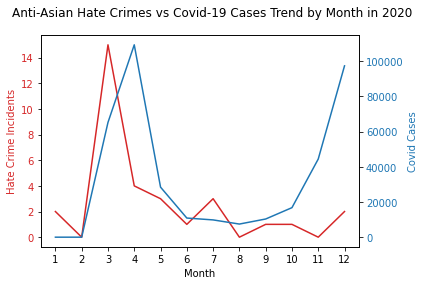

In [17]:
fig, ax1 = plt.subplots()
fig.suptitle('Anti-Asian Hate Crimes vs Covid-19 Cases Trend by Month in 2020')
ax1.set_xlabel('Month')
ax1.set_ylabel('Hate Crime Incidents', color = 'tab:red')
ax1.plot(cases_by_month.toPandas().loc[:,'Month'], asian_hate_by_month.toPandas().loc[:,'Count'], color = 'tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('Covid Cases', color = 'tab:blue')
ax2.plot(cases_by_month.toPandas().loc[:,'Month'], cases_by_month.toPandas().loc[:,'Num'], color = 'tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
fig.tight_layout()
# plt.savefig("Hate and covid trend")
# plt.show()

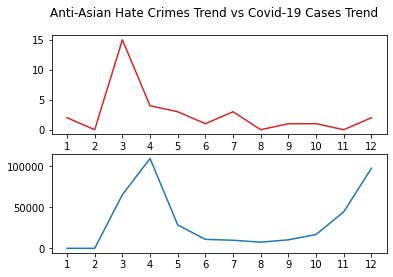

In [18]:
fig, axs = plt.subplots(2)
fig.suptitle('Anti-Asian Hate Crimes Trend vs Covid-19 Cases Trend')
axs[0].plot(cases_by_month.toPandas().loc[:,'Month'], asian_hate_by_month.toPandas().loc[:,'Count'], color = 'tab:red')
axs[1].plot(cases_by_month.toPandas().loc[:,'Month'], cases_by_month.toPandas().loc[:,'Num'], color = 'tab:blue')

## Hate Crime Offense Catogory's Shift in 2019-2020

In [19]:
query = "select count(*) as Count, Offense_Category from crimes_2019 group by Offense_Category"
crimes_2019_category = spark.sql(query)
query = "select count(*) as Count, Offense_Category from crimes_2020 group by Offense_Category"
crimes_2020_category = spark.sql(query)
crimes_2019_category.toPandas()
# crimes_2020_category.toPandas()
# dfi.export(crimes_2020_category.toPandas(), 'crimes_20_category.png')

,Count,Offense_Category
0,66,Race/Color
1,277,Religion/Religious Practice
2,64,Sexual Orientation
3,22,Ethnicity/National Origin/Ancestry
4,1,Disability
5,3,Unclassified
6,13,Gender


([<matplotlib.patches.Wedge at 0x7f81d486bd68>,
 [Text(1.0726400308874446, 0.5379994090496585, 'Race/Color'),
  Text(-1.0628519026933152, 0.28345340523832085, 'Religion/Religious Practice'),
  Text(0.5941121739170606, -0.9257595394072612, 'Sexual Orientation'),
  Text(1.0155246182739945, -0.42274075942527445, 'Ethnicity/National Origin/Ancestry'),
  Text(1.0704155007024638, -0.25339821596825396, 'Disability'),
  Text(1.0771293750846356, -0.2231419040202511, 'Unclassified'),
  Text(1.0953913261823194, -0.1005874869183041, 'Gender')],
 [Text(0.6257066846843427, 0.3138329886123008, '14.8%'),
  Text(-0.5797374014690809, 0.15461094831181135, '62.1%'),
  Text(0.32406118577294213, -0.504959748767597, '14.3%'),
  Text(0.5539225190585424, -0.2305858687774224, '4.9%'),
  Text(0.583863000383162, -0.13821720870995668, '0.2%'),
  Text(0.5875251136825284, -0.12171376582922787, '0.7%'),
  Text(0.5974861779176287, -0.0548659019554386, '2.9%')])

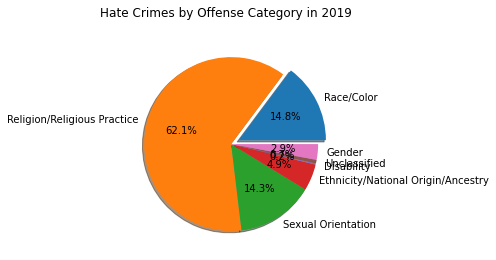

In [20]:
plt.suptitle('Hate Crimes by Offense Category in 2019')
explode1 = (0.1, 0, 0, 0, 0, 0, 0)
plt.pie(crimes_2019_category.toPandas()['Count'], explode = explode1, labels = crimes_2019_category.toPandas()['Offense_Category'], autopct='%1.1f%%', shadow=True)
# plt.savefig("Hate Crimes by Offense Category in 2019")

([<matplotlib.patches.Wedge at 0x7f81d49970b8>,
 [Text(1.0999317410349614, 0.01225418556243977, 'Age'),
  Text(0.7225338767615822, 0.9580943570086815, 'Race/Color'),
  Text(-1.072808903848063, -0.24306594953698843, 'Religion/Religious Practice'),
  Text(0.24306595267585177, -1.0728089031368917, 'Other'),
  Text(0.6623226946685343, -0.8782531799697691, 'Sexual Orientation'),
  Text(0.9872365559769722, -0.48514325981376555, 'Ethnicity/National Origin/Ancestry'),
  Text(1.0803318446768448, -0.20708236375202468, 'Gender')],
 [Text(0.5999627678372517, 0.006684101215876237, '0.4%'),
  Text(0.42147809477758963, 0.5588883749217308, '28.7%'),
  Text(-0.5851684930080343, -0.1325814270201755, '48.9%'),
  Text(0.13258142873228276, -0.5851684926201227, '1.1%'),
  Text(0.361266924364655, -0.47904718907441945, '12.4%'),
  Text(0.5384926668965302, -0.2646235962620539, '2.5%'),
  Text(0.5892719152782789, -0.11295401659201346, '6.0%')])

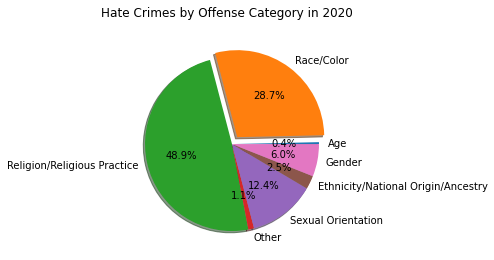

In [21]:
explode2 = (0, 0.1, 0, 0, 0, 0, 0)
plt.suptitle('Hate Crimes by Offense Category in 2020')
plt.pie(crimes_2020_category.toPandas()['Count'], explode = explode2, labels = crimes_2020_category.toPandas()['Offense_Category'], autopct='%1.1f%%', shadow=True)
# plt.savefig("Hate Crimes by Offense Category in 2020")

## Percentage of Anti-Asian Hate Crimes in 2019-2020

In [26]:
query = "select count(*) as Num, Bias_Motive from crimes_2020 where Offense_Category = 'Race/Color' group by Bias_Motive"
crimes_by_race_2020 = spark.sql(query)
crimes_by_race_2020.createOrReplaceTempView("res")
query = "select count(*) as Num, Bias_Motive from crimes_2019 where Offense_Category = 'Race/Color' group by Bias_Motive"
crimes_by_race_2019 = spark.sql(query)
crimes_by_race_2019.createOrReplaceTempView("res")
crimes_by_race_2019.toPandas()
# dfi.export(crimes_by_race_2020.toPandas(), 'crimes_20_race.png')

,Num,Bias_Motive
0,28,ANTI-WHITE
1,1,ANTI-MULTI RACIAL GROUPS
2,36,ANTI-BLACK
3,1,ANTI-ASIAN


In [27]:
crimes_by_race_2020.toPandas()

,Num,Bias_Motive
0,10,ANTI-WHITE
1,2,ANTI-MULTI RACIAL GROUPS
2,39,ANTI-BLACK
3,30,ANTI-ASIAN


([<matplotlib.patches.Wedge at 0x7f81d4ada9e8>,
 [Text(0.25933478659950576, 1.0689927354567892, 'ANTI-WHITE'),
  Text(-1.0005952318392295, 0.4569564333944747, 'ANTI-MULTI RACIAL GROUPS'),
  Text(-0.2593346865131817, -1.0689927597374596, 'ANTI-BLACK'),
  Text(1.2985275524329845, -0.061856249259093804, 'ANTI-ASIAN')],
 [Text(0.14145533814518496, 0.583086946612794, '42.4%'),
  Text(-0.5457792173668523, 0.24924896366971347, '1.5%'),
  Text(-0.14145528355264453, -0.583086959856796, '54.5%'),
  Text(0.7990938784202981, -0.03806538415944234, '1.5%')])

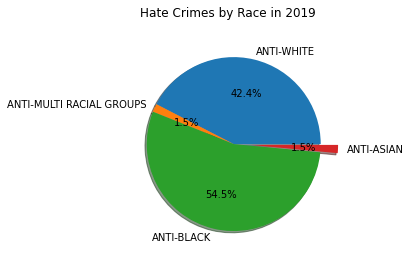

In [23]:
explode = (0, 0, 0, 0.2)
plt.suptitle('Hate Crimes by Race in 2019')
plt.pie(crimes_by_race_2019.toPandas()['Num'], explode = explode, labels = crimes_by_race_2019.toPandas()['Bias_Motive'], autopct='%1.1f%%', shadow=True)
# plt.savefig("Hate Crimes by Race in 2019")

([<matplotlib.patches.Wedge at 0x7f81d4b92a20>,
 [Text(1.0182963649936008, 0.4160198469313927, 'ANTI-WHITE'),
  Text(0.7232735001571103, 0.8287794905585458, 'ANTI-MULTI RACIAL GROUPS'),
  Text(-0.8426489168532446, 0.7070663355909783, 'ANTI-BLACK'),
  Text(0.4752957612765681, -1.101859310126537, 'ANTI-ASIAN')],
 [Text(0.5554343809056004, 0.22691991650803237, '12.3%'),
  Text(0.39451281826751466, 0.4520615403046613, '2.5%'),
  Text(-0.45962668191995154, 0.3856725466859881, '48.1%'),
  Text(0.2772558607446647, -0.6427512642404798, '37.0%')])

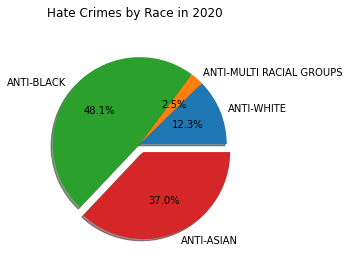

In [24]:
explode = (0, 0, 0, 0.1)
plt.suptitle('Hate Crimes by Race in 2020')
plt.pie(crimes_by_race_2020.toPandas()['Num'], explode = explode, labels = crimes_by_race_2020.toPandas()['Bias_Motive'], autopct='%1.1f%%', shadow=True)
# plt.savefig("Hate Crimes by Race in 2020")